In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import scipy.stats as sts
import seaborn as sns
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf


# from scipy.signal import convolve2d
from statsmodels.formula.api import ols

import lib.reconstruction.neighbors as nbrs
import lib.reconstruction.errors as errs

# from lib.utility_functions import *
# from lib.exp4 import *

sns.set_style('white')
sns.set_context('paper')

colors = sns.color_palette().as_hex()

pd.set_option('display.max_columns', 40)

% matplotlib inline

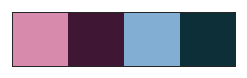

In [2]:
# colors = sns.color_palette('Oranges', n_colors=2).as_hex() + sns.color_palette('Blues', n_colors=2).as_hex()
colors = sns.cubehelix_palette(n_colors=2, start=0.5, hue=1, rot=.1, light=.65) 
colors += sns.cubehelix_palette(n_colors=2, start=2.5, hue=1, rot=.1, light=.65)
sns.palplot(colors)

# Average neighbors per board

Before looking at the effect on individual errors, we want to examine the effect of whole-board-neighborliness statistics on total errors per board.

There are three statistics per board: average fraction of all surrounding occupation, average fraction of same color surrounding occupation, average fraction of opposite color surrounding occupation.

Fraction should be used because of edge effects.

The two effects we should look at to start:
- Effect of adjacency statistic on total error
- Bias in adjacency statistics for final boards

We also need to check:
- Difference in adjacency statistic for real/fake boards

In [3]:
tidy = pd.read_csv('./tidy_data.csv', index_col=0)
tidy['Condition'] = tidy['Condition'].map(lambda x: 'Untrained' if x == 'Naive' else x)
tidy['Position ID'] = tidy['Position ID'].map(int)

vals = ['Black Position', 'White Position', 'Is Real', 'Num Pieces']

board_set = tidy.pivot_table(index='Position ID', values=vals, aggfunc=lambda x: x.unique()[0])[vals]


adjacency_df = pd.DataFrame(
    board_set.apply(nbrs.get_adjacency_per_location, axis=1).tolist(), 
    index=board_set.index, 
    columns=['adjacency_all', 'adjacency_same', 'adjacency_opposite']
)

errors_by_location_2 = tidy.apply(
    lambda x: errs.get_errors_per_location(x, '2'), 
    axis=1
)
    
tidy['ebl2'] = errors_by_location_2
pos_grouped = tidy.groupby('Position ID', )
mean_error_freq_by_loc = pos_grouped.apply(lambda df: np.stack(df['ebl2'], axis=1).mean(axis=1))
pos_grouped = tidy.groupby('Position ID', )
board_set['ebl2'] = pos_grouped.apply(lambda df: np.stack(df['ebl2'], axis=1).mean(axis=1))
board_set['location_idx'] = np.tile(np.arange(36, dtype=np.uint8), [len(board_set), 1]).tolist()
# board_set = board_set.loc[pd.notnull(board_set['ebl2'])]

sum_df = pd.concat([board_set, adjacency_df], axis=1)
sum_df = sum_df.loc[pd.notnull(sum_df['ebl2'])]

In [4]:
def filter_by_occupied(row, targ):
    ebl = row[targ]
    bp = row['Black Position']
    wp = row['White Position']
    
    filtered = []
    for i, (bi, wi) in enumerate(zip(bp, wp)):
        if bi == '1' or wi == '1':
            filtered.append(ebl[i])
            
    return filtered

sum_df['filtered_ebl'] = sum_df.apply(lambda row: filter_by_occupied(row, 'ebl2'), axis=1)
# for f in ['1111', '1110', '1101', '1100', '1010', '1001']:
#     sum_df['filtered_{}b'.format(f)] = sum_df.apply(lambda row: filter_by_occupied(row, '{}b'.format(f)), axis=1)
#     sum_df['filtered_{}w'.format(f)] = sum_df.apply(lambda row: filter_by_occupied(row, '{}w'.format(f)), axis=1)
sum_df['filtered_adjacency_same'] = sum_df.apply(lambda row: filter_by_occupied(row, 'adjacency_same'), axis=1)
sum_df['filtered_adjacency_opposite'] = sum_df.apply(lambda row: filter_by_occupied(row, 'adjacency_opposite'), axis=1)

In [13]:
# feature_list = ['1111', '1110', '1101', '1100', '1010', '1001']
# x = []
# for f in feature_list:
#     xb = [loc_val for board in sum_df['filtered_{}b'.format(f)] for loc_val in board]
#     xw = [loc_val for board in sum_df['filtered_{}w'.format(f)] for loc_val in board]
#     x_ = np.stack(xb) + np.stack(xw)
    
#     x.append(x_)
    
x_same = np.stack([loc_val for board in sum_df['filtered_adjacency_same'] for loc_val in board])
x_opposite = np.stack([loc_val for board in sum_df['filtered_adjacency_opposite'] for loc_val in board])

x = np.stack([x_same, x_opposite]).T #, np.ones_like(x_same)]).T
y = np.stack([loc_val for board in sum_df['filtered_ebl'] for loc_val in board])

model = sm.Logit(y, x)
result = model.fit()
result.summary(alpha=.02)

Optimization terminated successfully.
         Current function value: 0.449413
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 1380
Model:                          Logit   Df Residuals:                     1378
Method:                           MLE   Df Model:                            1
Date:                Wed, 12 Sep 2018   Pseudo R-squ.:                 -0.6135
Time:                        17:29:56   Log-Likelihood:                -620.19
converged:                       True   LL-Null:                       -384.37
                                        LLR p-value:                     1.000
==============================================================================
                 coef    std err          z      P>|z|       [0.01       0.99]
------------------------------------------------------------------------------
x1            -3.8099      0.346    -11.000      0.000      -4.616      -3.004
x2            -0.7628      0.248     -3.081      0.002      -1.339      -0.187
==============================================================================
"""

In [10]:
result.params

array([-3.58416433, -0.52600424, -0.13884893])

In [7]:
model.predict(result.params, np.arange(0, 1, .1)[:, np.newaxis])

ValueError: shapes (10,1) and (2,) not aligned: 1 (dim 1) != 2 (dim 0)

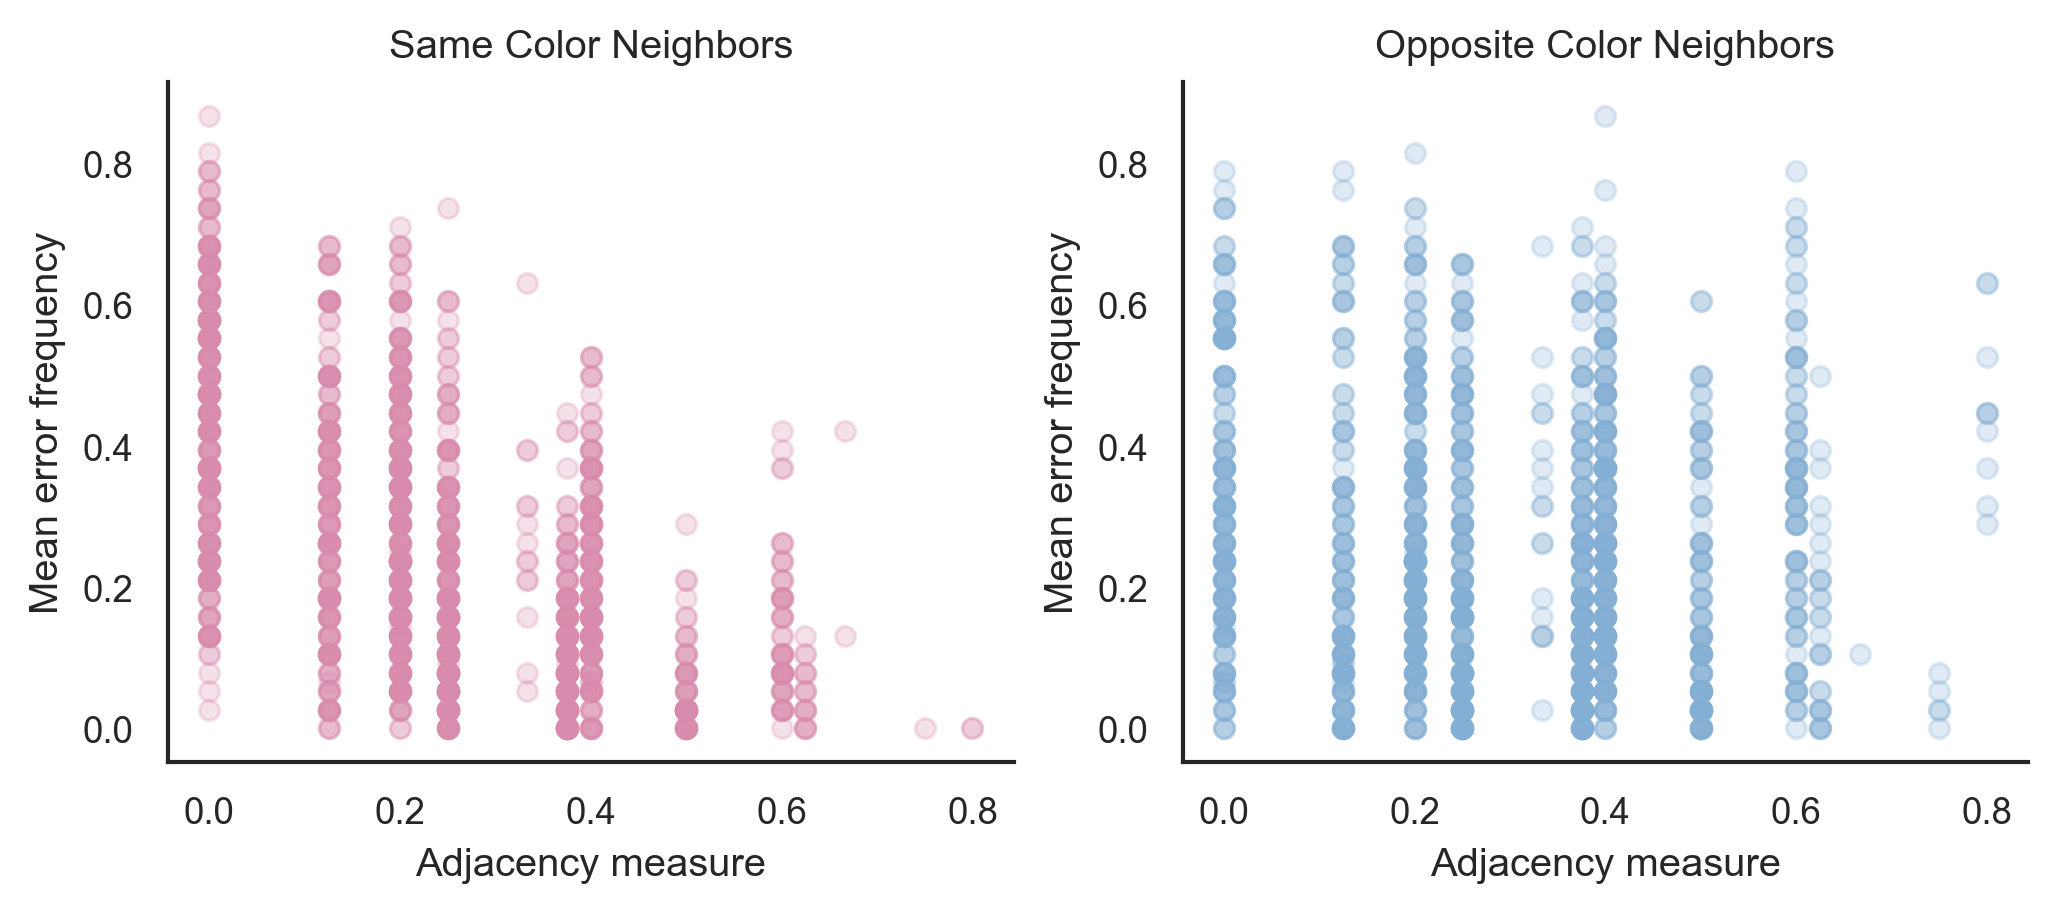

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3), dpi=300)

ax = axes[0]
ax.scatter(x_same, y, alpha=.25, color=colors[0])
plt.setp(ax, title='Same Color Neighbors')

# x_support = np.arange(0, 1, .1)
# predicted = model.predict(result.params, x_support[:, np.newaxis])

# axes.plot(x_support, predicted, color=colors[1], linewidth=2, zorder=-1)

ax = axes[1]
ax.scatter(x_opposite, y, alpha=.25, color=colors[2])
plt.setp(ax, title='Opposite Color Neighbors')


plt.setp(
    axes,
    ylabel='Mean error frequency',
    xlabel='Adjacency measure'
)
sns.despine()

In [12]:
x = np.stack(adjacencies_by_location.values).flatten()
x = np.stack([x, np.ones_like(x)]).T
y = np.stack(mean_error_freq_by_loc.values).flatten()

model = sm.OLS(y, x)
result = model.fit()
result.summary()

NameError: name 'adjacencies_by_location' is not defined

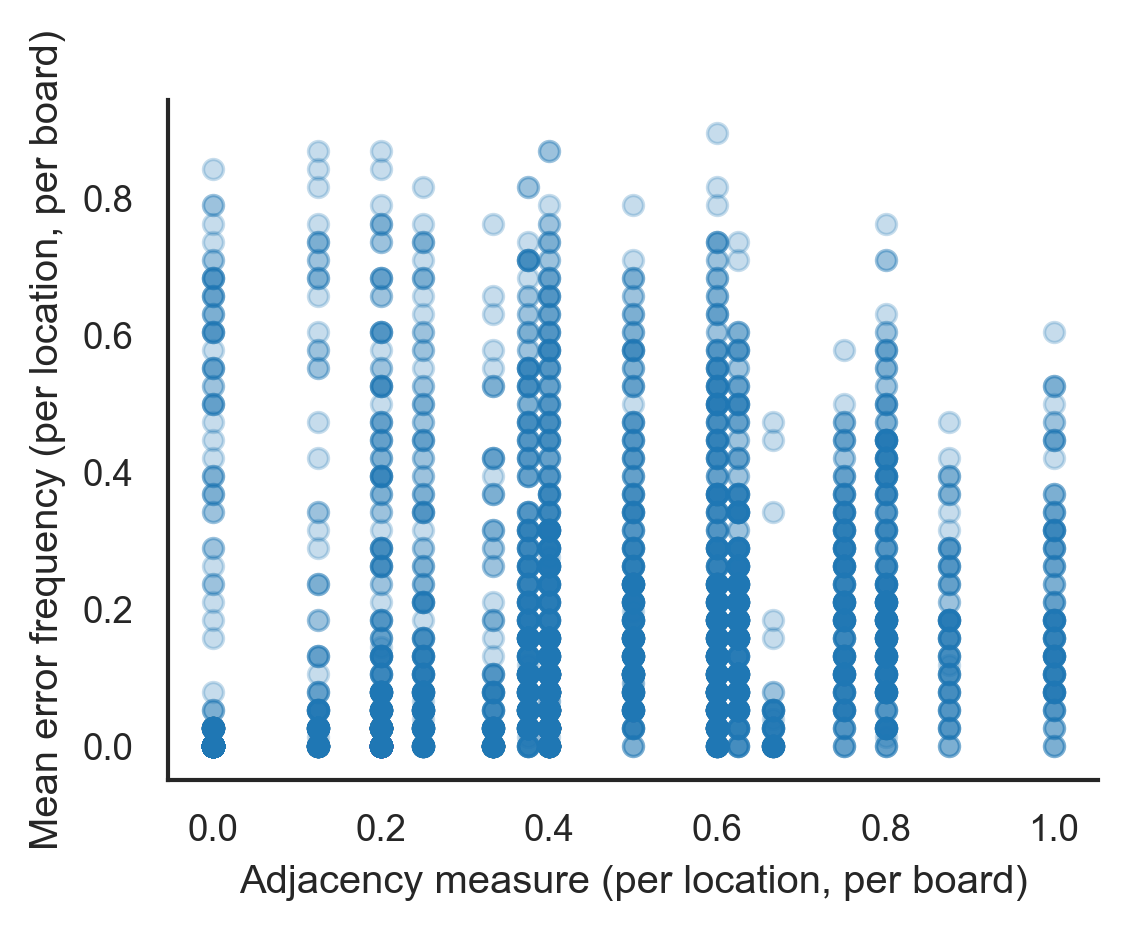

In [38]:
fig, axes = plt.subplots(1, 1, figsize=(4, 3), dpi=300)

axes.scatter(x, y, alpha=.25)
plt.setp(
    axes,
    ylabel='Mean error frequency (per location, per board)',
    xlabel='Adjacency measure (per location, per board)'
)
sns.despine()

In [32]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.438
Model:                            OLS   Adj. R-squared:                  0.437
Method:                 Least Squares   F-statistic:                     2659.
Date:                Thu, 02 Aug 2018   Prob (F-statistic):               0.00
Time:                        16:55:13   Log-Likelihood:                 772.93
No. Observations:                3420   AIC:                            -1544.
Df Residuals:                    3419   BIC:                            -1538.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.3424      0.007     51.569      0.000       0.329       0.355
==============================================================================
Omnibus:                      894.545   Durbin-Watson:                   1.774
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1991.673
Skew:                           1.490   Prob(JB):                         0.00
Kurtosis:                       5.257   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [27]:
mean_error_freq_by_loc.map(lambda x: x.shape[0])

Position ID
0     36
1     36
2     36
3     36
4     36
5     36
6     36
7     36
9     36
10    36
11    36
12    36
13    36
14    36
15    36
16    36
17    36
18    36
19    36
20    36
21    36
22    36
23    36
24    36
25    36
26    36
27    36
28    36
29    36
30    36
      ..
66    36
67    36
68    36
69    36
70    36
71    36
72    36
73    36
74    36
75    36
76    36
77    36
78    36
79    36
80    36
81    36
82    36
83    36
84    36
85    36
86    36
87    36
88    36
89    36
90    36
91    36
92    36
93    36
94    36
95    36
Length: 95, dtype: int64

In [7]:
tidy_adjacencies = tidy.apply(
    lambda x: get_adjacency(x, bp_name='Black Position (final)', wp_name='White Position (final)'),
    axis=1
)

/Users/gianni/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:40: RuntimeWarning: Mean of empty slice.
/Users/gianni/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/gianni/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:39: RuntimeWarning: Mean of empty slice.


In [8]:
board_set = pd.concat([board_set, adjacencies], axis=1)

In [9]:
tidy['Cond. Total Adj (final)'] = tidy_adjacencies['Cond. Total']
tidy['Total Adj (final)'] = tidy_adjacencies['Total']

tidy['Cond. Total Adj'] = tidy['Position ID'].map(lambda x: board_set.loc[x, 'Cond. Total'])
tidy['Total Adj'] = tidy['Position ID'].map(lambda x: board_set.loc[x, 'Total'])

In [10]:
tidy['Errors by loc'] = errors_by_location

Total T-Test: 0.012, 0.81, 0.42097
Cond. Total T-Test: 0.117, 6.36, 0.00000
Same T-Test: 0.038, 3.46, 0.00081
Opposite T-Test: 0.044, 3.87, 0.00020


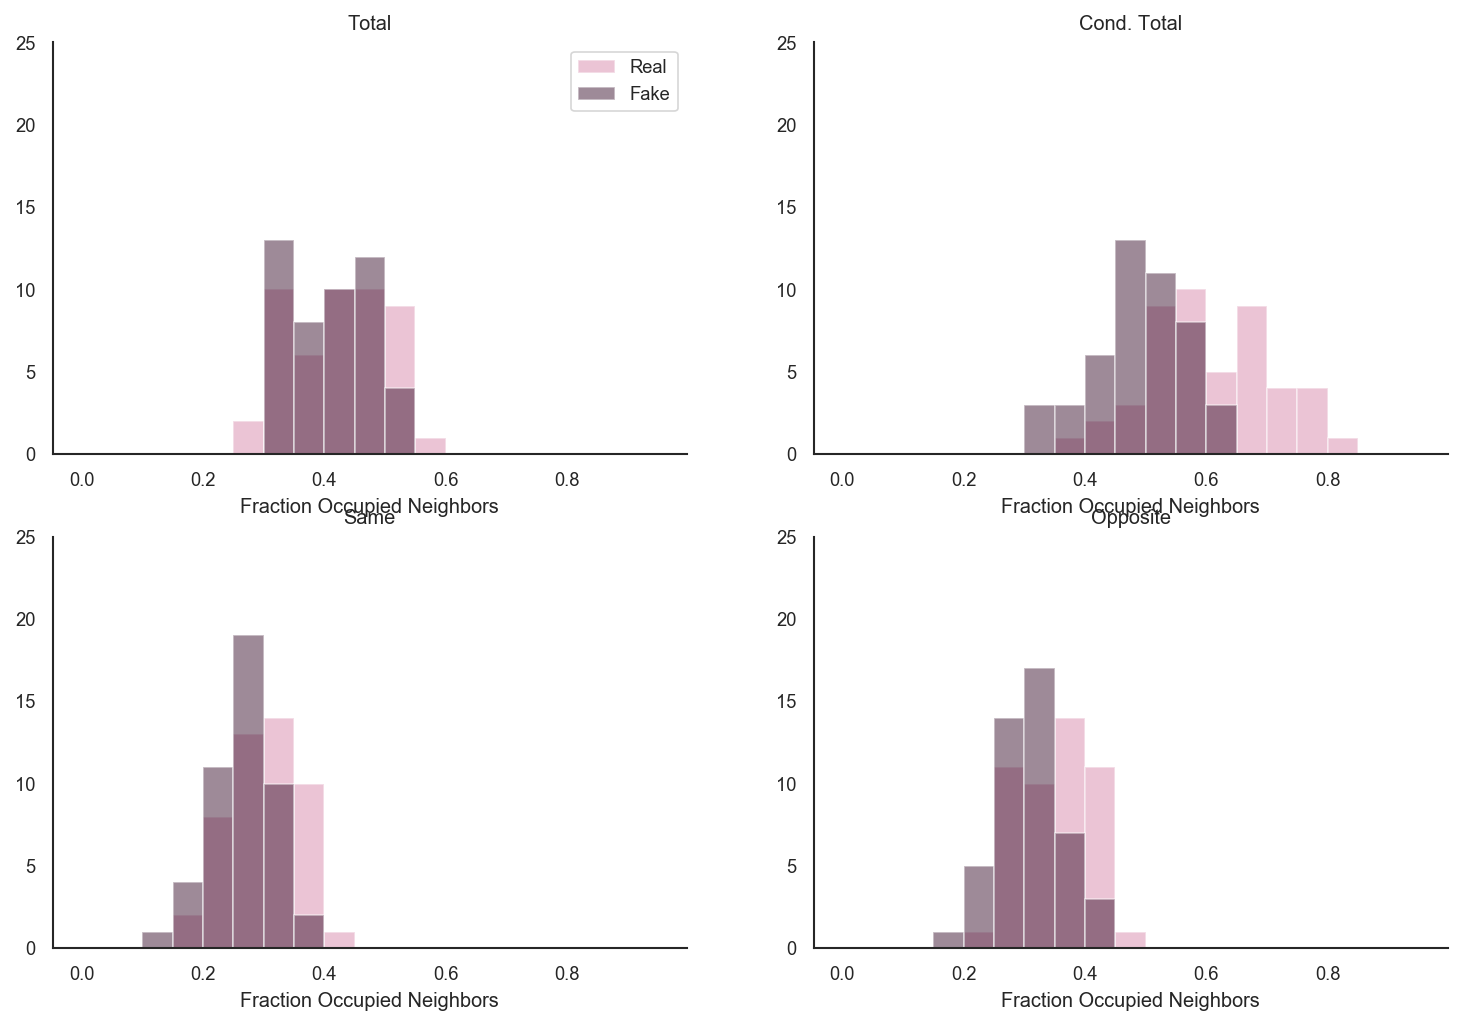

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8), dpi=150)

for i, col in enumerate(['Total', 'Cond. Total', 'Same', 'Opposite']):
    ax = axes.flatten()[i]
    y0 = board_set.loc[board_set['Is Real'], col].values
    y1 = board_set.loc[~board_set['Is Real'], col].values

    ax.hist(y0, bins=np.arange(0, 1, .05), alpha=.5, label='Real', color=colors[0])
    ax.hist(y1, bins=np.arange(0, 1, .05), alpha=.5, label='Fake', color=colors[1])
    
    plt.setp(ax, title=col)
    
    ttest_result = sts.ttest_ind(y0, y1)
    
    print(
        col, 'T-Test: {:.3f}, {:.2f}, {:.5f}'.format((y0.mean() - y1.mean()), ttest_result.statistic, ttest_result.pvalue)
    )

axes[0, 0].legend(loc=0)

plt.setp(
    axes, 
    xlabel='Fraction Occupied Neighbors',
    ylim=[0, 25]
)

sns.despine()

#### Test these bubbies for multicollinearity

In [16]:
tidy.head()

,Subject ID,Condition,Game Index,Position ID,Is Real,Black Position,White Position,Black Position (final),White Position (final),Response Time,Num Black Pieces,Num White Pieces,Num Pieces,Total Black Errors,Total White Errors,Total Errors,Type I Errors (black),Type I Errors (white),Type I Errors,Type II Errors (black),Type II Errors (white),Type II Errors,Type III Errors (black),Type III Errors (white),Type III Errors,Num Pieces (final),Numerosity Error,Cond. Total Adj (final),Total Adj (final),Cond. Total Adj,Total Adj,Errors by loc
0,1464109333721,Trained,0,25,False,000000000011010000010100000001010001,001100000000001000001000000010100010,000000000011010000010100100001000000,000100000000100010001011000000000100,43.957,8,7,15,3,10,13.0,1,5,6,2,5,7,0,0,0,14,1,0.542857,0.462500,0.568889,0.430787,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, ..."
2,1464109333721,Trained,1,92,True,001011000000011000000101000000010100,000100000001100100000010100001101000,000001000001011000000101000000010100,000100000000100100001010100000101000,36.897,9,9,18,3,3,5.0,0,1,1,2,1,3,0,1,1,16,2,0.748438,0.469444,0.802778,0.500000,"[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
4,1464109333721,Trained,2,16,False,100100000001010000000100000000101000,000010000010000100001001000001000000,100100000001010000000101000000100000,000001000010000100001000000000000000,17.922,7,6,13,2,4,5.0,0,1,1,1,2,3,0,1,1,11,2,0.400758,0.325231,0.450641,0.368287,"[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6,1464109333721,Trained,3,75,True,000001001000101100001001000000010000,000100000001010000010110000000001000,000001001001001100000101000000010000,000100000000110000000010000000001000,22.380,8,7,15,4,4,5.0,0,0,0,1,1,2,1,2,3,13,2,0.643750,0.372917,0.641071,0.448843,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, ..."
8,1464109333721,Trained,4,69,True,000101000101100000001100000000000000,000000000010011000000001000000111000,000101000101100000001100000000000000,000000000010011000000001000000111000,20.494,7,7,14,0,0,0.0,0,0,0,0,0,0,0,0,0,14,0,0.544643,0.415046,0.544643,0.415046,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [17]:
board_set['Num Pieces'] = board_set.apply(
    lambda row: np.sum(np.stack([int(i) for i in row['Black Position']]) + np.stack([int(i) for i in row['White Position']])),
    axis=1
)

LinregressResult(slope=0.028788771189759955, intercept=-0.00043893354013874175, rvalue=0.939412323829111, pvalue=5.018801601120083e-45, stderr=0.0010893128423149015)
LinregressResult(slope=0.026012148133340355, intercept=0.2297425911773996, rvalue=0.5976223044891263, pvalue=7.2983709316849295e-06, stderr=0.005145463619491247)
LinregressResult(slope=0.02007471655856129, intercept=0.1981502369306387, rvalue=0.612181807925757, pvalue=4.816193343110832e-06, stderr=0.00386530565722574)


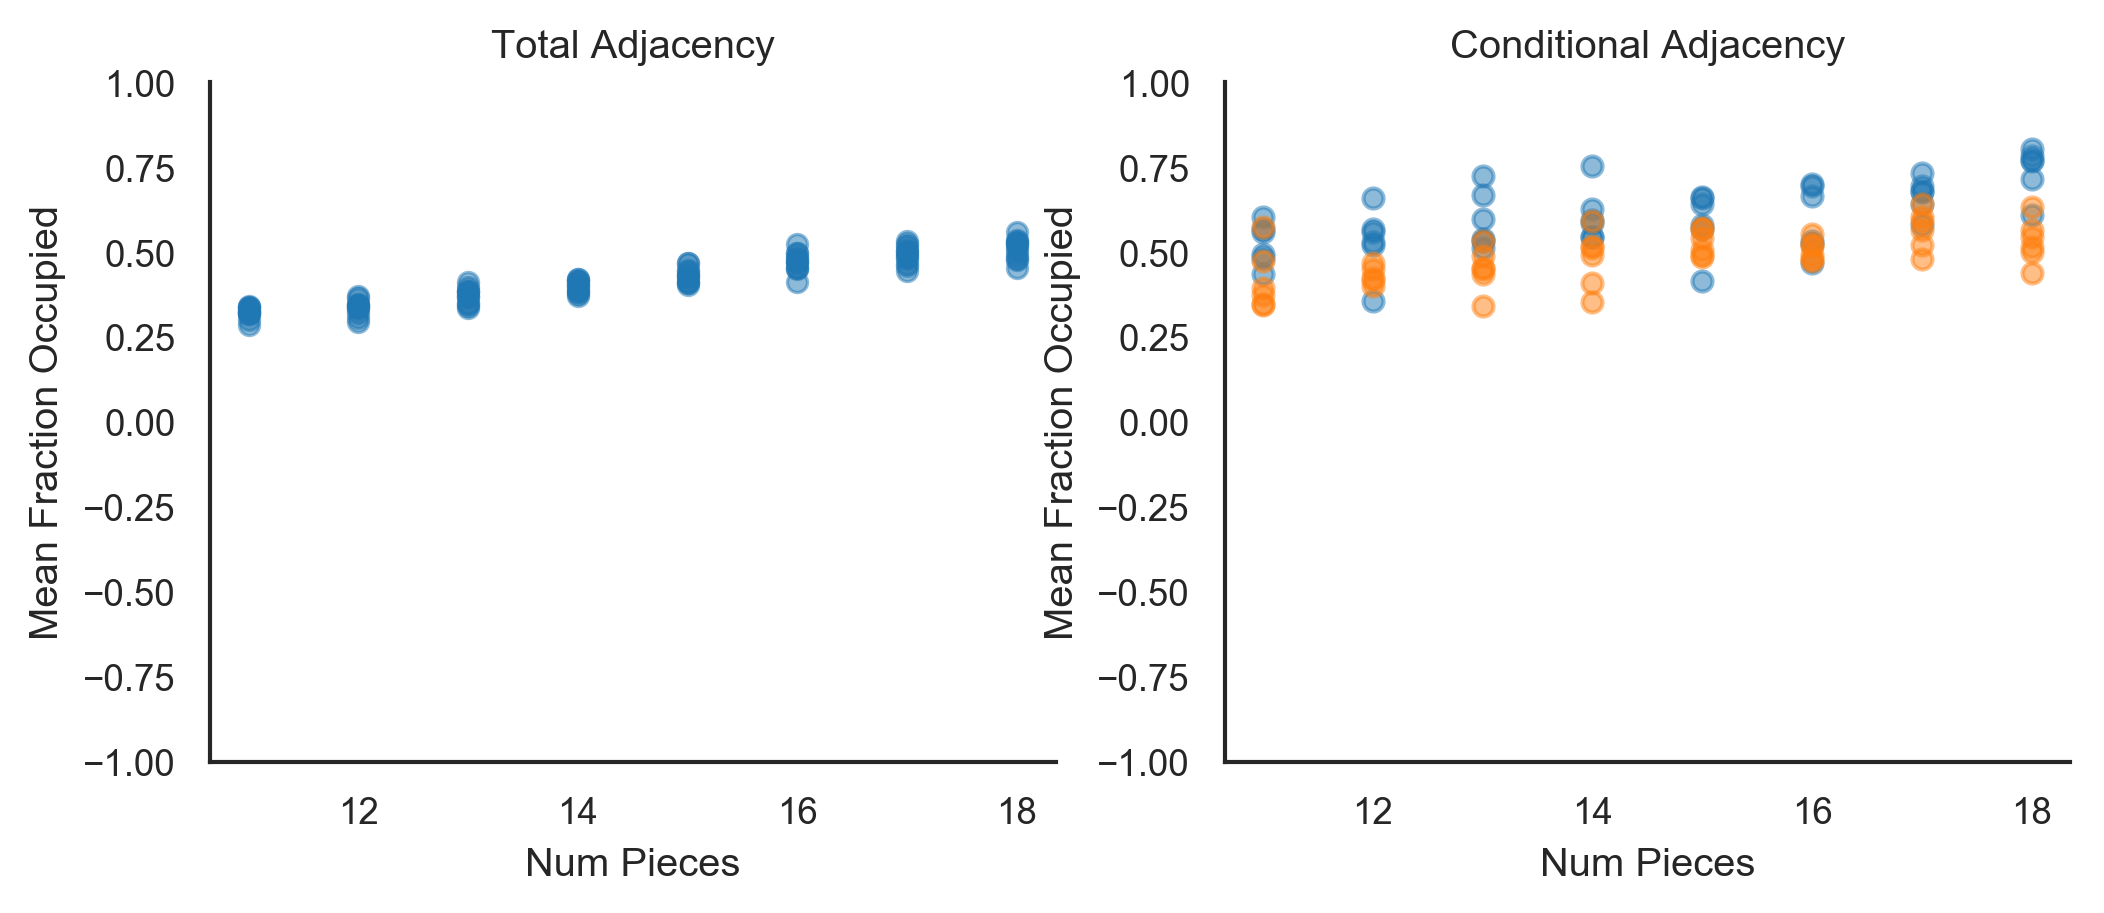

In [18]:
x = board_set['Num Pieces']
y1 = board_set['Total']
y2 = board_set['Cond. Total']

fig, axes = plt.subplots(1, 2, figsize=(8, 3), dpi=300)
print(sts.linregress(x, y1))
# print(sts.linregress(x, y2))

axes[0].scatter(x, y1, alpha=.5)

r = board_set['Is Real'] == True
x_real = board_set.loc[r, 'Num Pieces']
y2_real = board_set.loc[r, 'Cond. Total']
axes[1].plot(x_real, y2_real, alpha=.5, linestyle='none', marker='o')
print(sts.linregress(x_real, y2_real))

x_fake = board_set.loc[~r, 'Num Pieces']
y2_fake = board_set.loc[~r, 'Cond. Total']
axes[1].plot(x_fake, y2_fake, alpha=.5, linestyle='none', marker='o')
print(sts.linregress(x_fake, y2_fake))


plt.setp(
    axes,
    xlabel='Num Pieces',
    ylim=[-1, 1], ylabel='Mean Fraction Occupied'
)

plt.setp(axes[0], title='Total Adjacency')
plt.setp(axes[1], title='Conditional Adjacency')
sns.despine()

Woof.

In [19]:
total_adj_means = board_set.pivot_table(index='Num Pieces', values='Total')
cond_adj_means = board_set.pivot_table(index='Num Pieces', values='Total')

In [20]:
board_set['Adjusted Total'] = board_set.apply(
    lambda row: row['Total'] - total_adj_means.loc[row['Num Pieces']],
    axis=1
)

board_set['Adjusted Cond.'] = board_set.apply(
    lambda row: row['Cond. Total'] - total_adj_means.loc[row['Num Pieces']],
    axis=1
)

tidy['Adjusted Total'] = tidy['Position ID'].map(lambda x: board_set.loc[x, 'Adjusted Total'])
tidy['Adjusted Cond.'] = tidy['Position ID'].map(lambda x: board_set.loc[x, 'Adjusted Cond.'])

In [167]:
tidy['num_pieces'] = tidy['Num Pieces'] / 36
tidy['neighborhood_size'] = tidy['Cond. Total Adj']
tidy['y'] = tidy['Total Errors']


NBFam = sm.families.NegativeBinomial()

formula1 = 'y ~ num_pieces + neighborhood_size'
formula2 = 'y ~ num_pieces'
formula3 = 'y ~ neighborhood_size'
formula4 = 'y ~ C(num_pieces) + neighborhood_size'

def get_nbr_params(formula, condition='Trained', is_real=True):
    models = []
    c = tidy['Condition'] == condition
    r = tidy['Is Real'] == is_real
    
    T = tidy.loc[c & r]
    
    for subject_id in T['Subject ID'].unique():
        p = T['Subject ID'] == subject_id
        S = T.loc[p]
        
        model = smf.glm(formula=formula, data=S, family=NBFam)
        model = model.fit(method='bfgs', maxiter=10000)
        models.append(model)
        
    params = pd.DataFrame([m.params for m in models], index=T['Subject ID'].unique())
    pvals = pd.DataFrame([m.pvalues for m in models], index=T['Subject ID'].unique())
    lls = pd.DataFrame([{'ll': m.llf} for m in models], index=T['Subject ID'].unique())
    
    for df in [params, pvals, lls]:
        df['Condition'] = condition
        df['Is Real'] = is_real

    return params, pvals, lls, models


def get_nbr_partial_corr(condition='Trained', is_real=True):
    models1 = []
    models2 = []
    corrs = []
    c = tidy['Condition'] == condition
    r = tidy['Is Real'] == is_real
        
    for subject_id in tidy.loc[c, 'Subject ID'].unique():
        p = tidy['Subject ID'] == subject_id
        
        f1 = 'y ~ num_pieces'
        m1 = smf.glm(formula=f1, data=tidy.loc[r&p], family=NBFam)
        m1 = m1.fit(method='bfgs', maxiter=10000)
        
        tidy.loc[c&r&p, 'res1'] = m1.resid_response
        
        f2 = 'neighborhood_size ~ num_pieces'
        m2 = smf.glm(f2, data=tidy.loc[r&p], family=sm.families.Gaussian())
        m2 = m2.fit(maxiter=10000)
        
        tidy.loc[c&r&p, 'res2'] = m2.resid_response
        
        models1.append(m1)
        models2.append(m2)
        
        corr = sts.spearmanr(m1.resid_response, m2.resid_response)
        corrs.append(corr)
        
    params = pd.DataFrame([m.params for m in models], index=tidy.loc[c, 'Subject ID'].unique())
    pvals = pd.DataFrame([m.pvalues for m in models], index=tidy.loc[c, 'Subject ID'].unique())
    lls = pd.DataFrame([{'ll': m.llf} for m in models], index=tidy.loc[c, 'Subject ID'].unique())
    corrs = pd.DataFrame(
        [{'corr': corr, 'pval': pval} for corr, pval in corrs], 
        index=tidy.loc[c, 'Subject ID'].unique()
    )
    
    for df in [params, pvals, lls, corrs]:
        df['Condition'] = condition
        df['Is Real'] = is_real

    return corrs

In [168]:
corr_list = []
for condition in ['Trained', 'Untrained']:
    for is_real in [True, False]:
        corrs = get_nbr_partial_corr(condition=condition, is_real=is_real)
        corr_list.append(corrs)
        
corr_df = pd.concat(corr_list)

In [169]:
corr_df.pivot_table(
    index='Condition', columns='Is Real', values='pval', aggfunc=np.mean
)

Is Real,False,True
Condition,,
Trained,0.447342,0.116355
Untrained,0.329035,0.055787


In [177]:
param_dfs = []
pvals_dfs = []
lls_dfs = []
models_list = []

for condition in ['Trained', 'Untrained']:
    for is_real in [True, False]:
        param_df, pvals_df, lls_df, models = get_nbr_params(formula1, condition=condition, is_real=is_real)

        param_dfs.append(param_df)
        pvals_dfs.append(pvals_df)
        lls_dfs.append(lls_df)
        models_list.append(models)
        
params = pd.concat(param_dfs)
pvals = pd.concat(pvals_dfs)
lls1 = pd.concat(lls_dfs)

In [180]:
param_dfs = []
pvals_dfs = []
lls_dfs = []
models_list = []

for condition in ['Trained', 'Untrained']:
    for is_real in [True, False]:
        param_df, pvals_df, lls_df, models = get_nbr_params(formula3, condition=condition, is_real=is_real)
        param_dfs.append(param_df)
        pvals_dfs.append(pvals_df)
        lls_dfs.append(lls_df)
        models_list.append(models)
        
params = pd.concat(param_dfs)
pvals = pd.concat(pvals_dfs)
lls2 = pd.concat(lls_dfs)

In [106]:
bics1 = [m.bic for ms in models_list for m in ms]
lls1 = [m.llf for ms in models_list for m in ms]

In [110]:
bics2 = [m.bic for ms in models_list for m in ms]
lls2 = [m.llf for ms in models_list for m in ms]

In [114]:
f_idx = lls1['Condition'] == 'Trained'
f_col = lls1['Is Real'] == True

sts.chisquare(2 * lls1['ll'] - lls2['ll'], ddof=1)

Power_divergenceResult(statistic=-178.82230298010415, pvalue=1.0)

In [117]:
print(np.mean(bics1), np.mean(bics2))#, np.mean(bics3))

-153.83186445298884 -132.5331967776855


In [118]:
sts.chisquare(2 * (np.stack(lls1) - np.stack(lls2)), ddof=1)

TypeError: ufunc 'subtract' did not contain a loop with signature matching types dtype('<U9') dtype('<U9') dtype('<U9')

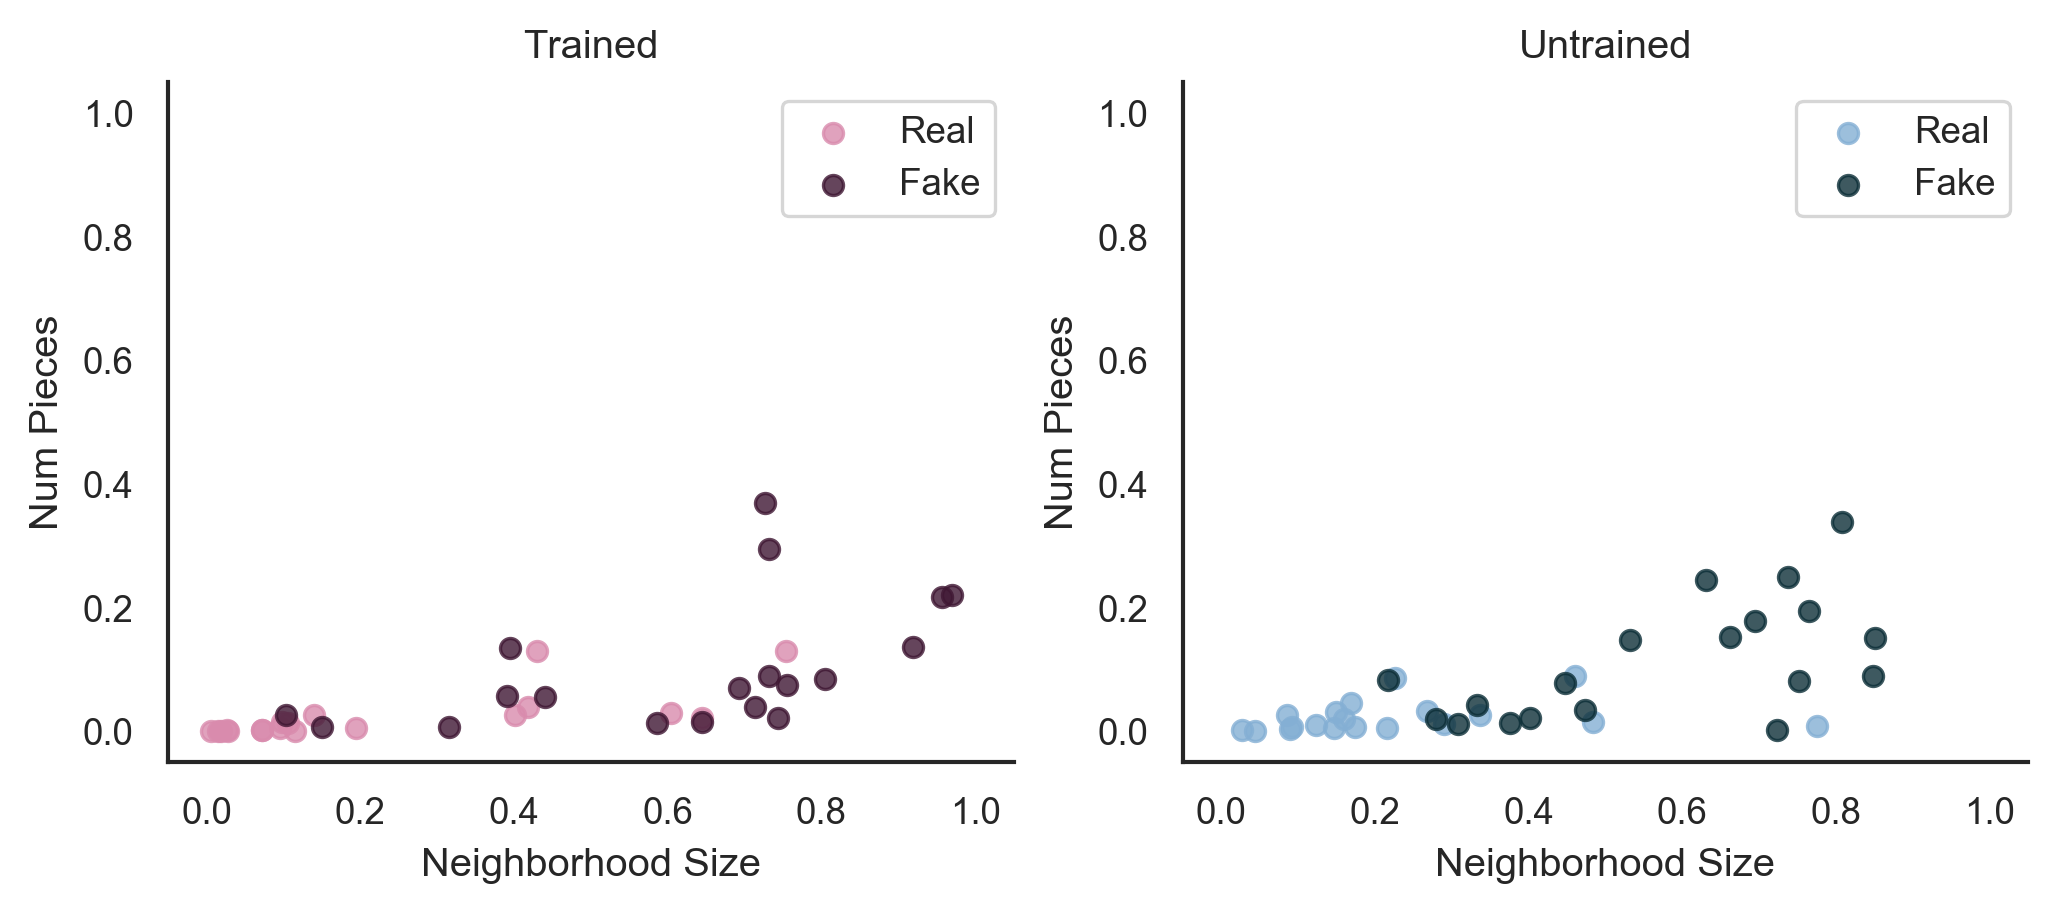

In [171]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3), dpi=300)

f_idx_pvals = pvals['Condition'] == 'Trained'
f_col_pvals = pvals['Is Real'] == True

ax = axes[0]

p = pvals.loc[f_idx_pvals & f_col_pvals]
s = p['neighborhood_size']
n = p['num_pieces']

ax.scatter(s, n, color=colors[0], alpha=.8, label='Real')
# ax.hist(s, bins=np.arange(0, 1, .05), color=colors[5], alpha=.5)
# ax = axes[0, 1]

p = pvals.loc[f_idx_pvals & ~f_col_pvals]
s = p['neighborhood_size']
n = p['num_pieces']

ax.scatter(s, n, color=colors[1], alpha=.8, label='Fake')

ax.legend(loc=0)


ax = axes[1]

p = pvals.loc[~f_idx_pvals & f_col_pvals]
s = p['neighborhood_size']
n = p['num_pieces']

ax.scatter(s, n, color=colors[2], alpha=.8, label='Real')
# ax.hist(s, bins=np.arange(0, 1, .05), color=colors[5], alpha=.5)
# ax = axes[0, 1]

p = pvals.loc[~f_idx_pvals & ~f_col_pvals]
s = p['neighborhood_size']
n = p['num_pieces']

ax.scatter(s, n, color=colors[3], alpha=.8, label='Fake')

ax.legend(loc=0)

plt.setp(
    axes, 
    xlim=[-.05, 1.05], ylim=[-.05, 1.05],
    xlabel='Neighborhood Size',
    ylabel='Num Pieces'
)


plt.setp(axes[0], title='Trained')
plt.setp(axes[1], title='Untrained')

sns.despine()

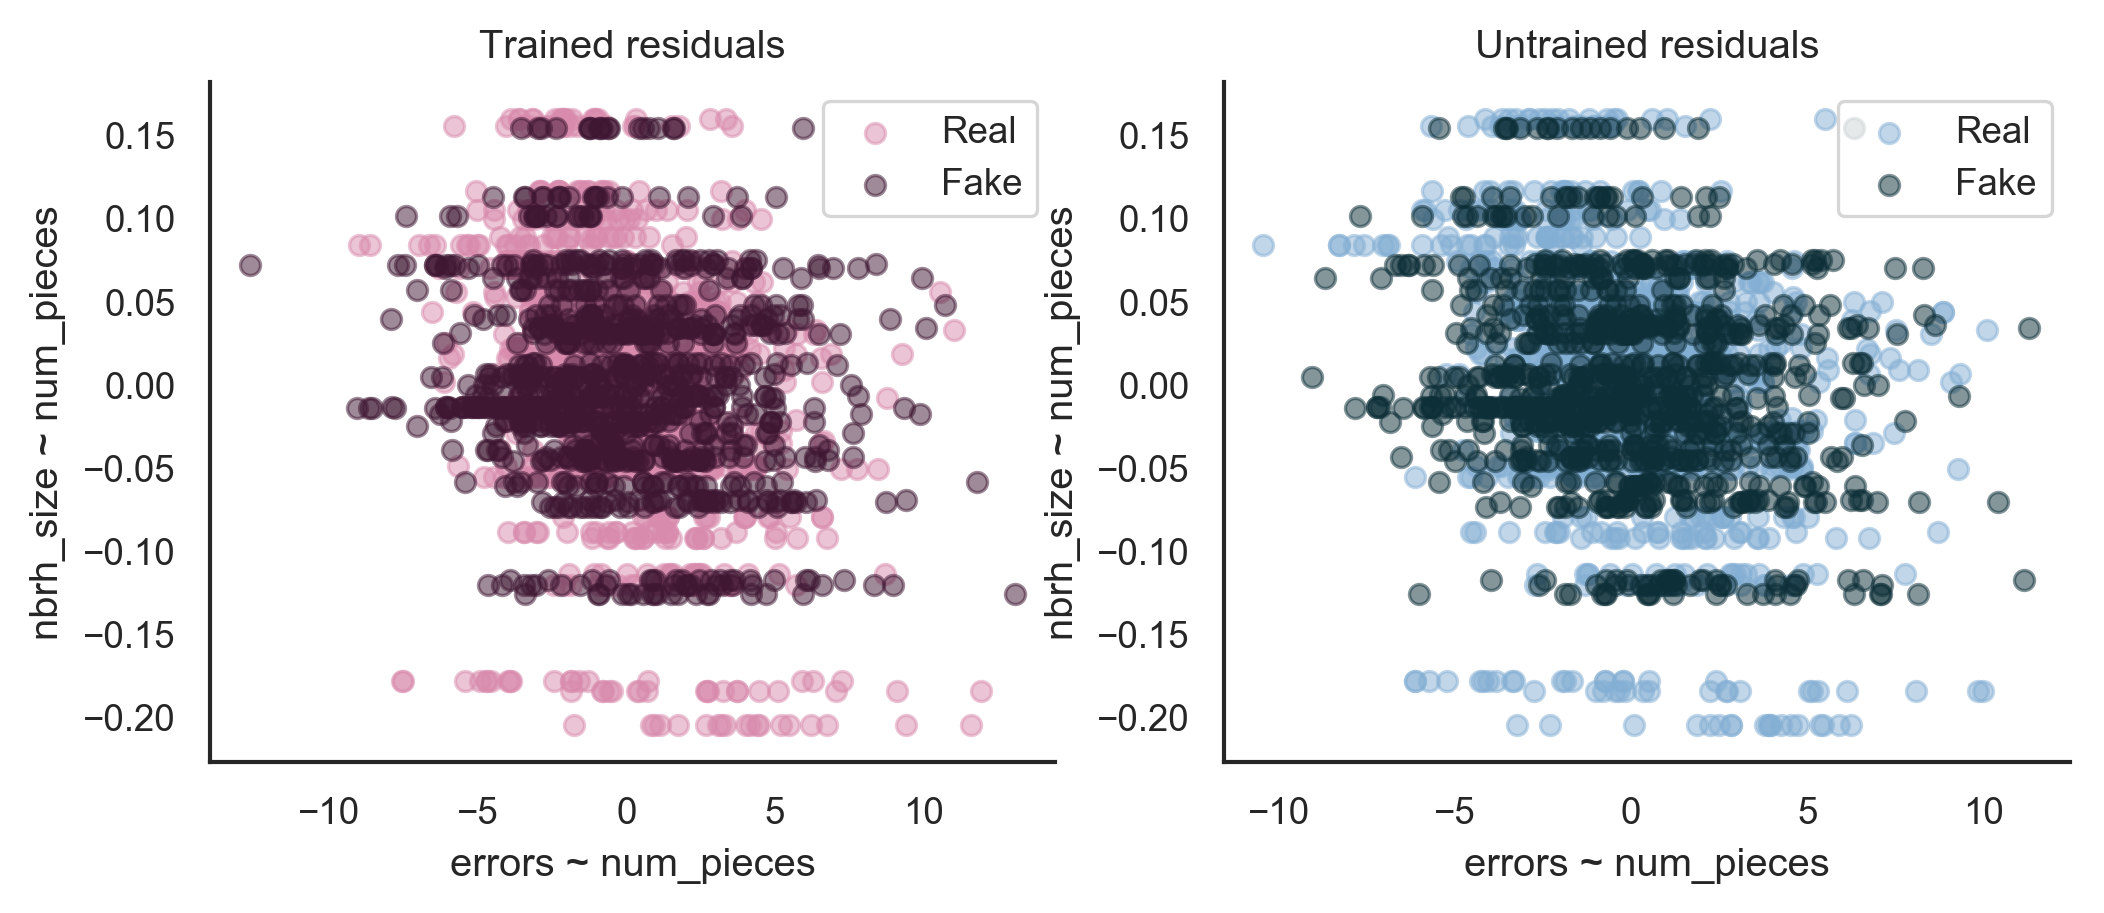

In [163]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3), dpi=300)

c = tidy['Condition'] == 'Trained'
r = tidy['Is Real'] == True

ax = axes[0]
x = tidy.loc[c & r, 'res1']
y = tidy.loc[c & r, 'res2']
ax.scatter(x, y, color=colors[0], alpha=.5, label='Real')

x = tidy.loc[c & ~r, 'res1']
y = tidy.loc[c & ~r, 'res2']
ax.scatter(x, y, color=colors[1], alpha=.5, label='Fake')

ax.legend(loc=0)
plt.setp(ax, title='Trained residuals')

ax = axes[1]
x = tidy.loc[~c & r, 'res1']
y = tidy.loc[~c & r, 'res2']
ax.scatter(x, y, color=colors[2], alpha=.5, label='Real')

x = tidy.loc[~c & ~r, 'res1']
y = tidy.loc[~c & ~r, 'res2']
ax.scatter(x, y, color=colors[3], alpha=.5, label='Fake')
ax.legend(loc=0)

plt.setp(ax, title='Untrained residuals')

plt.setp(
    axes,
    xlabel='errors ~ num_pieces',
    ylabel='nbrh_size ~ num_pieces'
)

sns.despine()

In [172]:
nbs_mean_pvals = corr_df.pivot_table(
    index='Condition', columns='Is Real', values='pval', 
    aggfunc=np.mean
)

nbs_mean_pvals.columns.name = 'PVALS NGHBRS'
nbs_mean_pvals.index.name = ''
nbs_mean_pvals

PVALS NGHBRS,False,True
,,
Trained,0.447342,0.116355
Untrained,0.329035,0.055787


In [181]:
nbs_mean_pvals = pvals.pivot_table(
    index='Condition', columns='Is Real', values='neighborhood_size', 
    aggfunc=np.mean
)

nbs_mean_pvals.columns.name = 'PVALS NGHBRS'
nbs_mean_pvals.index.name = ''
nbs_mean_pvals

PVALS NGHBRS,False,True
,,
Trained,0.476668,0.621539
Untrained,0.520358,0.656646


In [178]:
nps_mean_pvals = pvals.pivot_table(
    index='Condition', columns='Is Real', values='num_pieces', 
    aggfunc=np.mean
)

nps_mean_pvals.columns.name = 'PVALS NPCS'
nps_mean_pvals.index.name = ''
nps_mean_pvals

PVALS NPCS,False,True
,,
Trained,0.101055,0.023189
Untrained,0.111575,0.022318


## Position difficulty

In [186]:
difficulties = tidy.pivot_table(
    index='Position ID', columns='Condition', values='Total Errors',
    aggfunc=np.mean
)

# These are total errors, so more is WORSE
neighborhood_type = 'Cond. Total Adj'

In [187]:
difficulties['Is Real'] = difficulties.index.map(
    lambda x: tidy.loc[tidy['Position ID'] == x, 'Is Real'].values[0]
)

difficulties['neighborhood_size'] = difficulties.index.map(
    lambda x: tidy.loc[tidy['Position ID'] == x, neighborhood_type].values[0]
)

In [188]:
difficulties.head()

Condition,Trained,Untrained,Is Real,neighborhood_size
Position ID,,,,
0,7.368421,6.736842,False,0.348333
1,5.157895,4.947368,False,0.372500
2,2.368421,2.789474,False,0.475000
3,4.157895,4.526316,False,0.344444
4,2.578947,4.105263,False,0.393182


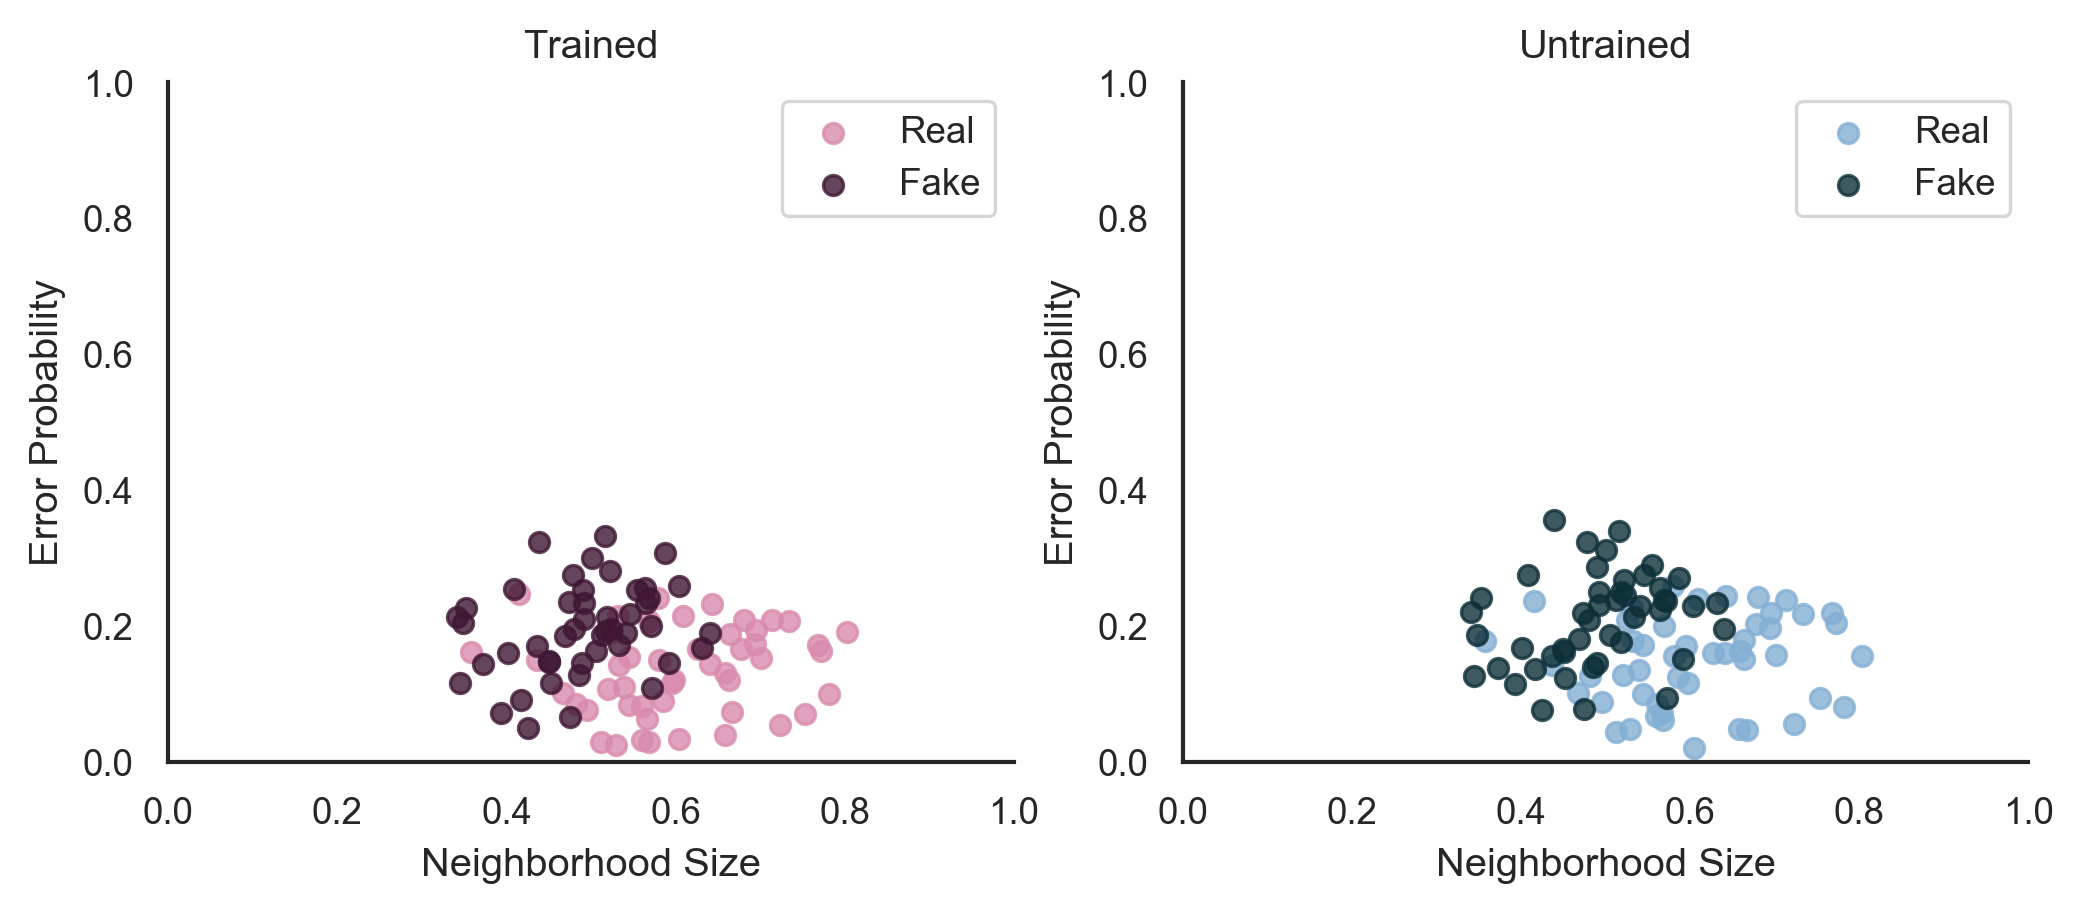

In [189]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3), dpi=300)

f_col = difficulties['Is Real'] == True

ax = axes[0]

d = difficulties.loc[f_col]
ax.scatter(d['neighborhood_size'], d['Trained'] / 36, color=colors[0], label='Real', alpha=.8)

d = difficulties.loc[~f_col]
ax.scatter(d['neighborhood_size'], d['Trained'] / 36, color=colors[1], label='Fake', alpha=.8)

ax.legend(loc=0)
plt.setp(ax, title='Trained')

ax = axes[1]

d = difficulties.loc[f_col]
ax.scatter(d['neighborhood_size'], d['Untrained'] / 36, color=colors[2], label='Real', alpha=.8)

d = difficulties.loc[~f_col]
ax.scatter(d['neighborhood_size'], d['Untrained'] / 36, color=colors[3], label='Fake', alpha=.8)

ax.legend(loc=0)
plt.setp(ax, title='Untrained')

plt.setp(
    axes,
    xlim=[0, 1], xlabel='Neighborhood Size',
    ylim=[0, 1], ylabel='Error Probability'
)


sns.despine()

In [241]:
sts.linregress(difficulties.loc[f_col, 'neighborhood_size'], difficulties.loc[f_col, 'Untrained']/36)

LinregressResult(slope=0.5561365175789905, intercept=-0.08731390189769736, rvalue=0.630110619695727, pvalue=1.5944104238807293e-06, stderr=0.10104856904161583)

### Locations

In [296]:
def get_error_by_adjacency_per_loc(row):
    position_id = row.name
    mean_error_by_loc = np.stack(tidy.loc[tidy['Position ID'] == position_id, 'Errors by loc'].values).mean(axis=0)
    
    return mean_error_by_loc


adj_frame = pd.DataFrame(adjacencies_by_location, columns=['Adjacency by loc'])
adj_frame['Mean errors by loc'] = adj_frame.apply(get_error_by_adjacency_per_loc, axis=1)

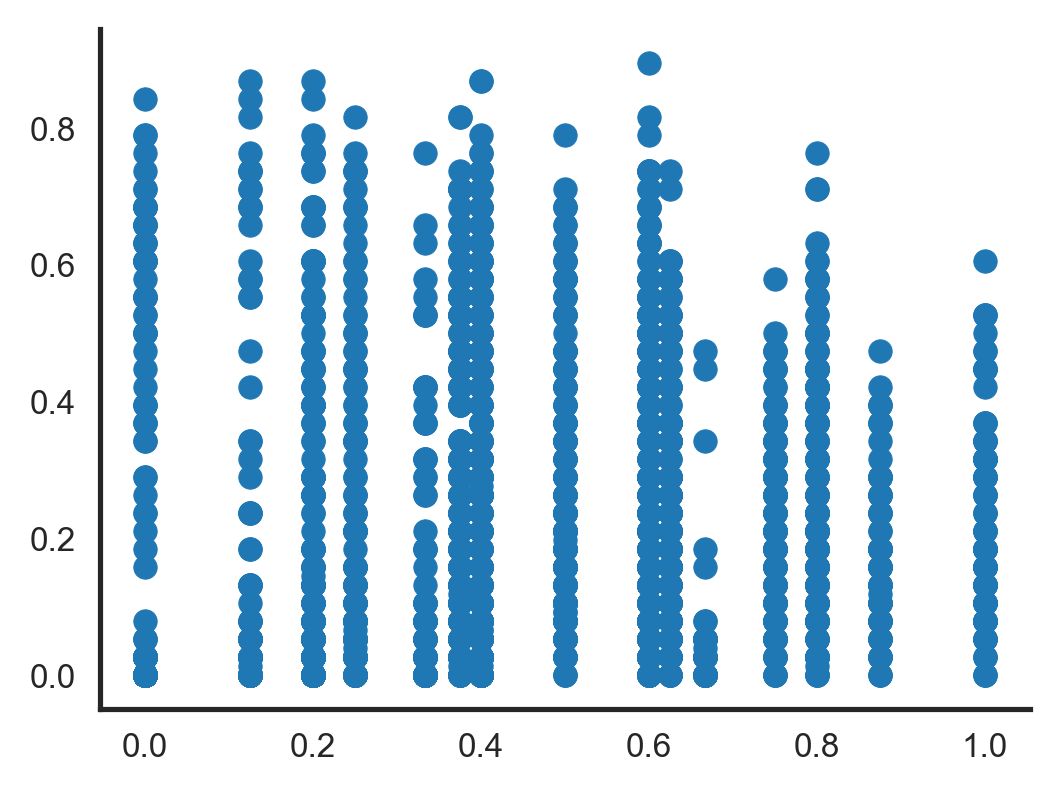

In [301]:
fig, axes = plt.subplots(1, 1, figsize=(4, 3), dpi=300)

x = np.stack(adj_frame['Adjacency by loc']).flatten()
y = np.stack(adj_frame['Mean errors by loc']).flatten()

axes.scatter(x, y)
sns.despine()

In [288]:
np.stack(tidy['Errors by loc'].iloc[:10].values).mean(axis=0).shape

(36,)

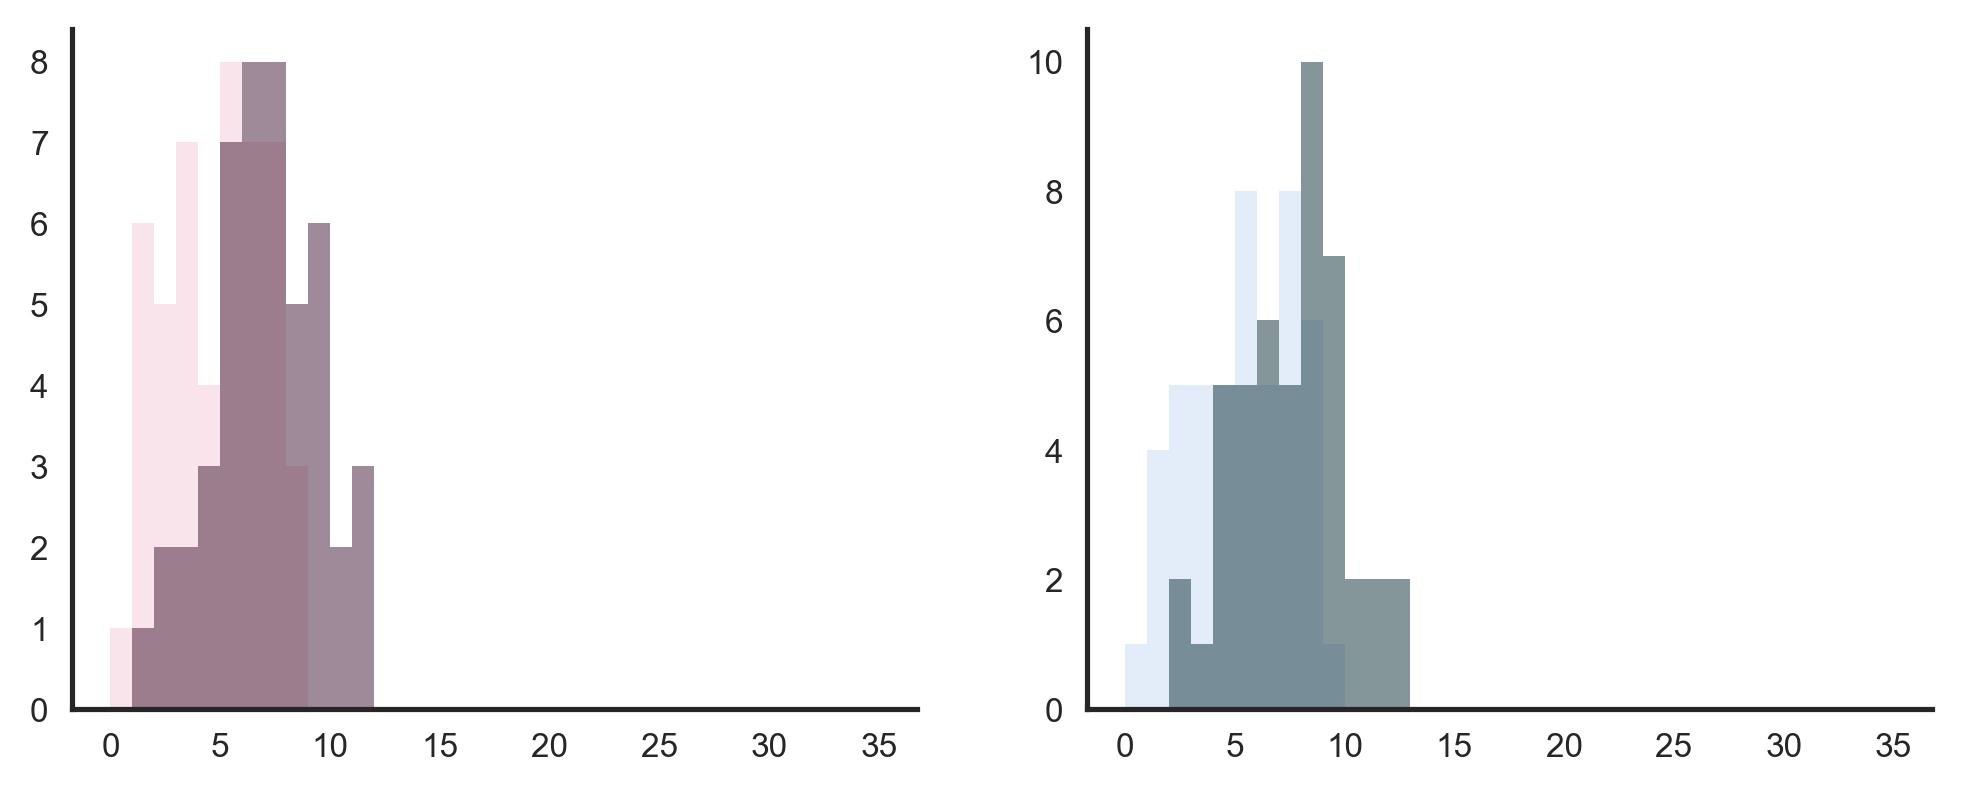

In [222]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3), dpi=300)

ax = axes[0]
f_col = difficulties['Is Real'] == True

ax.hist(difficulties.loc[f_col, 'Trained'], color=colors[0], bins=np.arange(0, 36, 1), alpha=.5, label='Real')
ax.hist(difficulties.loc[~f_col, 'Trained'], color=colors[1], bins=np.arange(0, 36, 1), alpha=.5, label='Fake')

ax = axes[1]

ax.hist(difficulties.loc[f_col, 'Untrained'], color=colors[2], bins=np.arange(0, 36, 1), alpha=.5, label='Real')
ax.hist(difficulties.loc[~f_col, 'Untrained'], color=colors[3], bins=np.arange(0, 36, 1), alpha=.5, label='Fake')

sns.despine()

In [22]:
m = models_list[0][0]

In [31]:
m.pvalues

Intercept            0.001179
num_pieces           0.000009
neighborhood_size    0.028029
dtype: float64

In [13]:
idx_names = ['Trained', 'Untrained']
col_names = [False, True]

results = pd.DataFrame(index=idx_names, columns=col_names)

In [ ]:
for idx in idx_names:
    for col in col_names:
        f_idx = tidy['Condition'] == idx
        f_col = tidy['Is Real'] == col
        t = tidy.loc[f_idx & f_col]
        
        formula = 'e ~ num_pieces + '

In [7]:
y0.mean()

0.35171144797638365

In [8]:
y1.mean()

0.3075314441271888

In [9]:
sts.ttest_ind(y0, y1)

Ttest_indResult(statistic=3.8678532529041045, pvalue=0.0002034666268523859)

In [12]:
#     x0 = tidy.loc[c_filter & s_filter, adj_type].values
#     x1 = tidy.loc[~c_filter & s_filter, adj_type].values

#     y0 = tidy.loc[c_filter & s_filter, adj_type + ' (final)'].values
#     y1 = tidy.loc[~c_filter & s_filter, adj_type + ' (final)'].values

In [13]:
c_filter = tidy['Condition'] == 'Trained'


def all_subject_regress(adj_type):

    regressions = {}

    for subject in tidy['Subject ID'].unique():
        s_filter = tidy['Subject ID'] == subject


        x = tidy.loc[s_filter, adj_type].values
        y = tidy.loc[s_filter, adj_type + ' (final)'].values

        regressions[subject] = sts.linregress(x, y)
        
    regression_result = pd.DataFrame.from_dict(
        {k: {'slope': v.slope, 'intercept': v.intercept} for k, v in regressions.items()}, 
        orient='index'
    )
    
    regression_result['Condition'] = regression_result.index.map(
        lambda x: tidy.loc[tidy['Subject ID'] == x, 'Condition'].values[0]
    )
    
    return regression_result

In [14]:
def all_subject_regression_histogram(regression_result, ax, value='slope'):
    r_s_filter = regression_result['Condition'] == 'Trained'

    h0 = regression_result.loc[r_s_filter, value].values
    h1 = regression_result.loc[~r_s_filter, value].values
    
    ax.hist(h0, bins=np.arange(0, 1, .05), alpha=.5, label='Trained')
    ax.hist(h1, bins=np.arange(0, 1, .05), alpha=.5, label='Untrained')
    
    return (h0.mean() - h1.mean()), sts.ttest_ind(h0, h1)



0.05280548326743251 Ttest_indResult(statistic=0.9082710216637652, pvalue=0.36977549795595)
0.007573853008236875 Ttest_indResult(statistic=0.18837424750121823, pvalue=0.8516411681701397)


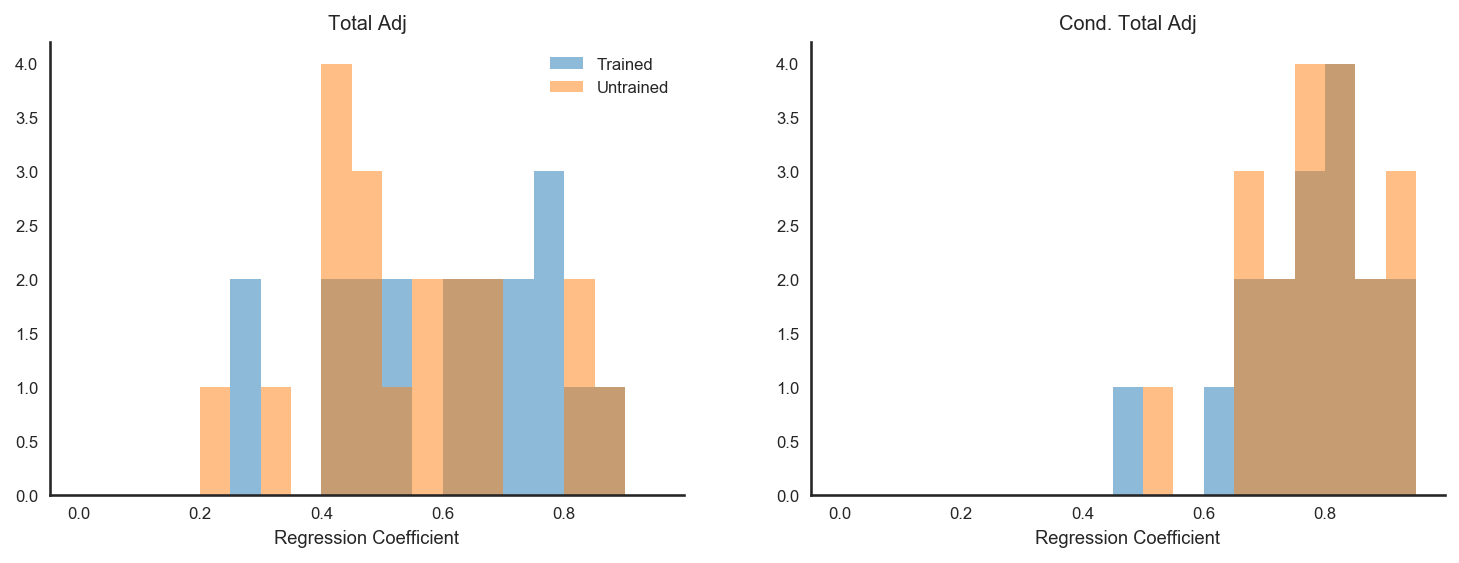

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), dpi=150)
regression_result = all_subject_regress('Total Adj')
dif, res = all_subject_regression_histogram(regression_result, axes[0])

print(dif, res)
plt.setp(axes[0], title='Total Adj')
axes[0].legend(loc=0)

regression_result = all_subject_regress('Cond. Total Adj')
dif, res = all_subject_regression_histogram(regression_result, axes[1])
print(dif, res)
plt.setp(axes[1], title='Cond. Total Adj')

plt.setp(axes, xlabel='Regression Coefficient')
sns.despine()

In [17]:
p = tidy.pivot_table(
    index='Subject ID', values=['Cond. Total Adj (final)', 'Cond. Total Adj', 'Total Adj (final)', 'Total Adj'],
    aggfunc=np.mean
)

In [20]:
p['Condition'] = p.index.map(
    lambda x: tidy.loc[tidy['Subject ID'] == x, 'Condition'].values[0]
)

In [23]:
p

,Cond. Total Adj,Cond. Total Adj (final),Total Adj,Total Adj (final),Condition
Subject ID,,,,,
1455888279254,0.54793,0.553825,0.416737,0.396171,Trained
1455896400640,0.54793,0.521374,0.416737,0.365813,Trained
1455905621344,0.54793,0.533416,0.416737,0.406399,Trained
1455913823185,0.54793,0.505197,0.416737,0.351153,Trained
1455999209774,0.54793,0.510725,0.416737,0.396443,Trained
1456159044009,0.54793,0.472095,0.416737,0.302821,Trained
1456327572567,0.54793,0.531392,0.416737,0.395935,Trained
1456358134808,0.54793,0.472934,0.416737,0.327382,Trained
1456775026965,0.54793,0.535123,0.416737,0.382844,Trained


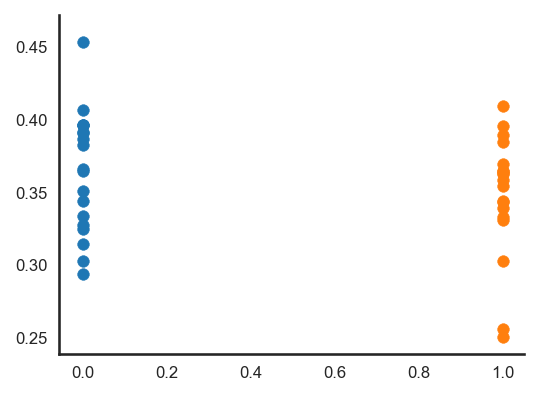

In [36]:
fig, axes = plt.subplots(1, 1, figsize=(4, 3), dpi=150)

condition_filter = p['Condition'] == 'Trained'



x = p.loc[condition_filter, 'Total Adj']
y0 = p.loc[condition_filter, 'Total Adj (final)']
y1 = p.loc[~condition_filter, 'Total Adj (final)']

axes.scatter(np.zeros_like(y0), y0)
axes.scatter(np.ones_like(y1), y1)
sns.despine()

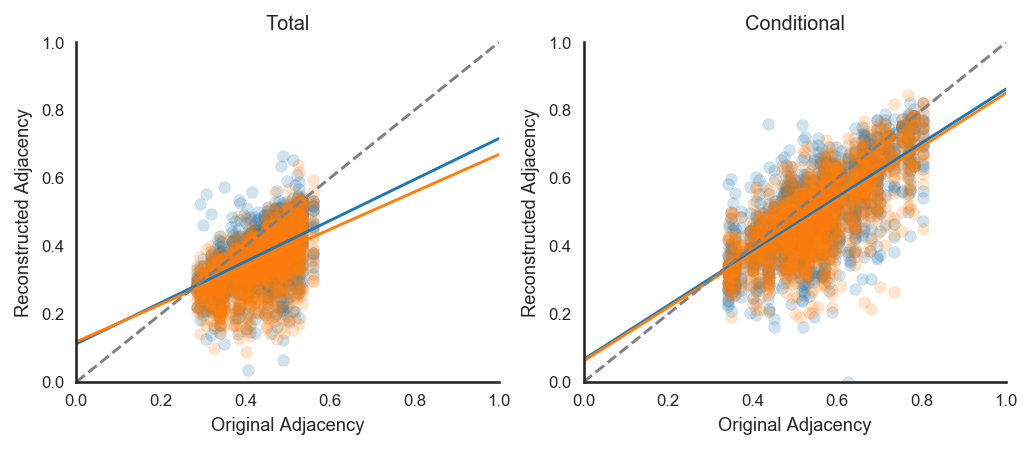

In [64]:
fig, axes_ = plt.subplots(1, 2, figsize=(8, 3), dpi=150)


p_ = tidy
condition_filter = p_['Condition'] == 'Trained'


axes = axes_[1]
x0 = p_.loc[condition_filter, 'Cond. Total Adj']
x1 = p_.loc[~condition_filter, 'Cond. Total Adj']

y0 = p_.loc[condition_filter, 'Cond. Total Adj (final)']
y1 = p_.loc[~condition_filter, 'Cond. Total Adj (final)']

m0 = sts.linregress(x0, y0)
m1 = sts.linregress(x1, y1)

axes.scatter(x0, y0, alpha=.2)
axes.scatter(x1, y1, alpha=.2)

axes.plot(np.arange(0, 1.1, .1), m0.slope * np.arange(0, 1.1, .1) + m0.intercept)
axes.plot(np.arange(0, 1.1, .1), m1.slope * np.arange(0, 1.1, .1) + m1.intercept)

axes.plot([0, 1], [0, 1], color='grey', linestyle='--')


axes = axes_[0]

x0 = p_.loc[condition_filter, 'Total Adj']
x1 = p_.loc[~condition_filter, 'Total Adj']

y0 = p_.loc[condition_filter, 'Total Adj (final)']
y1 = p_.loc[~condition_filter, 'Total Adj (final)']

m0 = sts.linregress(x0, y0)
m1 = sts.linregress(x1, y1)

axes.scatter(x0, y0, alpha=.2)
axes.scatter(x1, y1, alpha=.2)

axes.plot(np.arange(0, 1.1, .1), m0.slope * np.arange(0, 1.1, .1) + m0.intercept)
axes.plot(np.arange(0, 1.1, .1), m1.slope * np.arange(0, 1.1, .1) + m1.intercept)

axes.plot([0, 1], [0, 1], color='grey', linestyle='--')

plt.setp(
    axes_, 
    xlim=[0, 1], ylim=[0, 1],
    xlabel='Original Adjacency', ylabel='Reconstructed Adjacency'
)

plt.setp(axes_[1], title='Conditional')
plt.setp(axes_[0], title='Total')


sns.despine()

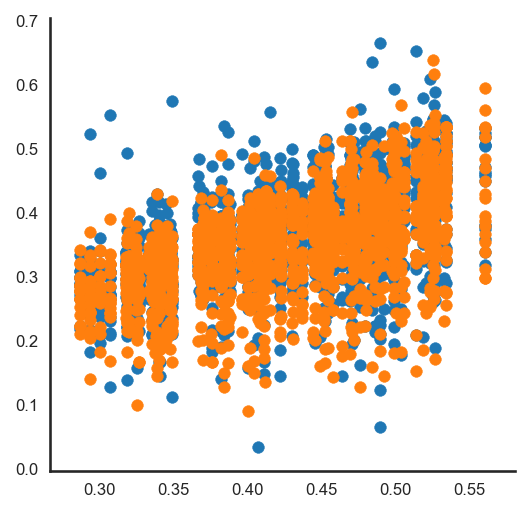

In [22]:
fig, axes = plt.subplots(1, 1, figsize=(4, 4), dpi=150)

axes.scatter(x0, y0)
axes.scatter(x1, y1)

sns.despine()

In [20]:
sts.linregress(x0, y0)

LinregressResult(slope=0.6041955528001488, intercept=0.11254305368961165, rvalue=0.5468665953503946, pvalue=8.8447000423438e-143, stderr=0.021670124787715392)

In [21]:
sts.linregress(x1, y1)

LinregressResult(slope=0.5513900695327161, intercept=0.11839076051081696, rvalue=0.5227539749404402, pvalue=1.8307382836060346e-128, stderr=0.02106558096504544)